# Patent applications analysis

This notebook provides different statistics related to patent applications. **It is important to note that all the given numbers refers to granted patents approved by the USPTO (United State Patent and Trademark Office)**. Therefore the statistics highlighted do not cover all the patent applications all over the world, but since the US is the most important patent provider, our study gives an accurate overview of the trend in the world.


Our research aims to compare the evolution of patents application according to different countries, sectors, companies. Thus, the absolute number of patents is less relevent than its evolution over time.

This notebook includes the following studies :

    1) The evolution of granted patents around the world the past 10 years (from 2007 to 2017)
    2) The number of USPTO granted patent by countries
    3) A colorful map highlighting the dispertion of patents around the world
    4) The top companies delivering patents 
    5) The top countries delivering patents by general sectors in CPC (Cooperative Patent Classification)
    7) Spider charts for the top patents delivered countries displaying the popular sectors
    6) A study of the number of patents delivered for a specific sector (To be continued for the next milestone) 

**Important:** In order to keep the notebook shorter and more to the point, the core implementation is contained in the python file **implementations.py**, which carefully and thouroughly describes the purpose of each function. We kindly invite you to have a look at it. We will however give a brief description of what a functions does when it is first used.

In [1]:
%pylab inline
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import seaborn as sns 
import requests
from bs4 import BeautifulSoup
import folium
import json
import branca.colormap as cm
import warnings

warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


The file **implementations.py** contains the definitions of the functions used throughout the notebook.

In [2]:
from implementations import *

In order to manipulate the database, an API is provided. The latter will allow us to send queries which always start with the following base URL **BASE_URL 'http://www.patentsview.org/api/patents/query?'**

In ***implementations.py***, the function BASE_URL() returns this base URL as a helper function. 

It is possible to request a specific research by keywords.
For exemple we could search (using q) for all the patents granted since April 2007 and display the patent number and patent granted date (using f):

      Example : 
#### http://www.patentsview.org/api/patents/query?q={"_gte":{"patent_date":"2007-01-04"}}&f=["patent_number","patent_date"]

### Number of granted patents over the past 10 years

This section aims to display the evolution of granted patent from January 2007 to January 2017

The API cannot return more than 100000 patents in one request. Thus, we need to collect the number of patents by months first and then aggregate the results to obtain the number of patents over a year.

Let's display the number of granted patents in a table. We use **get_nb_patents_year** to get the number of granted patent for a given year (12 months).

In [ ]:
years = list(range(2007,2017))
list_nb_patent=[get_nb_patents_year(str(year)) for year in years]
df_nb_patent=pd.DataFrame(index=years)
df_nb_patent['nb_patents']=list_nb_patent
df_nb_patent

We can plot the numbers to have a better visualization of the number of granted patent.

In [ ]:
plot(years, df_nb_patent['nb_patents']/1000, 'r', marker= '.')
plt.ylabel('Granted patents in thousands')
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.title("Evolution of number of granted patents over the last decade")
plt.show()

### Number of granted patent delivered by countries

This section aims to display which countries are the top patent providers. In a given patent, multiple inventors might be cited. Those inventors can be located in different countries. In that case, +1 will be counted for a country if at least one of the inventor is in the given country. The number of patents between January 2016 and January 2017 was chosen for this study.

First, we read the excel file **location.xlsx** given by the USPTO website which contains all the countries which have delivered patents in the past. The country names are coded according to the Alpha-2 ISO norm ("US","GE","FR","CH",...)

In [ ]:
dfLocation=pd.read_excel(os.getcwd()+'/data/location.xlsx').fillna('')

We clean the countries list and keep the Alpha-2 ISO codes only 

In [ ]:
countries=list(set(list(dfLocation['country'])))
countries = [countries[i] for i in range(len(countries)) if (len(countries[i]) == 2 and countries[i]!='a"')]

The **get_nb_patent_country** function below returns the number of granted patents for a given country. It might be possible that some countries issue a large number of patents that exceeds 100'000 in the year which overwhelms the API capacity. In that case the API request is splited between the 6 first and 6 last months of the year, and the number of patents are summed up together. 

In [ ]:
dfNbPatents=pd.DataFrame(columns=['country','nb_patents'])
dfNbPatents['country']=countries
dfNbPatents['nb_patents']=list(map(lambda x: get_nb_patent_country(x),dfNbPatents['country']))

We just created the dataframe containing the patents data grouped by countries.

The number of patents are sorted by country and the barplot is displayed. We chose to plot the 15 top countries

In [ ]:
dfNbPatents.sort_values(by='nb_patents',inplace=True, ascending=False)
dfNbPatents.head(15).plot.bar(x='country', y='nb_patents', figsize=(17,5), grid=True)

Display the exact number for the 10 top patent delivered countries

In [ ]:
dfNbPatents.set_index(pd.Series(list(range(1,len(dfNbPatents) + 1))), inplace=True)
dfNbPatents.head(10)

### Choropleth map map of the granted patent distribution around the world


This section aims to display a vizual world map that highlights the granted patent dispersion across the countries. 

As there is a very large gap between the number of patents throughout the different countries, we opted for a **logarithmic scale** for a better vizualisation. Without loss of generality, we shall still be able to vizualize accurate relative differences between numbers.   

In [ ]:
# max_n is the maximum number of patents holder, which is the US
max_n = dfNbPatents['nb_patents'].max()
#Here, we set up a Colormap using the logarithmic scale as shades of Blue colors that will be used to color the map
colormap = cm.linear.PuBu.scale(0, round(math.log(max_n))).to_step(100)

In [ ]:
patents = dfNbPatents.copy()
#Take the log of the number of granted patents to match the logarithmic scale
log_nb = list(map(lambda x: math.log(x) if (x > 0) else 0 , patents['nb_patents']))
#In the below DataFrame, each country has now its 'logarithmic color code'
patents['log_color_code'] = log_nb
patents.head()

In [ ]:
#We need also to convert the table into a dictionnary, in order to map a feature to its number of patents.
patents_dict = patents.set_index('country')['log_color_code']

#Here we map each country to a color according to the "logarithmic" number of patents
color_dict = {key: colormap(patents_dict[key]) for key in patents_dict.keys()}

The function **ret_color** below, applies colors to the countries that were previously stored in **color_dict**.
In case a country does not appear in the list of patents, we assign the white color by default.

The JSON file **custom.geo.json** contains informations about the world countries. It is used to draw a Choropleth below.

We can now draw a chloropleth map that shows the number of patents around the world.

In [ ]:
m = folium.Map(location= [46.484, 8.1336],tiles='cartodbpositron',zoom_start=2)  

#Load the world map
countries_geo_path = 'data/custom.geo.json'
geo_json_data = json.load(open(countries_geo_path))

#Apply the colors using our defined function ret_color, desribed above
folium.GeoJson(geo_json_data,
               style_function=lambda feature: {
              'fillColor': ret_color(feature, color_dict),
              'weight': .5,
              'fillOpacity': 0.8
               }).add_to(m)

#Setting up the scale 
colormap = cm.linear.PuBu.scale(0, 170000).to_step(50)
colormap.caption = 'Number of patents'
m.add_child(colormap)

m.save('world.html')

Here is an overview of the distribution of granted patents over the world 

**The interactive map can be accessed [here](https://skagankose.github.io/ada_fall_2017/world.html).**

![Image](data/world_patent.png)

### GRANTED VS PENDING

Upon our initial milestone 2 objective, we wanted to compare how many patents application are granted. After digging deeper in the DataBase we found out that we can only obtain the granted patents. Therefore it will not be possible to carry out this comparison.

### TOP COMPANIES


This section aims to display the top companies patent publishers in the world. The function **get_company** below returns a dictionnary containing the companies as keys and their related number of patent application. 

To have a recent and significant number of patents we chose to analyse the patent applications over a recent period, namely here from the 1st of january 2017 to the 1st of may 2017. 

In [ ]:
# DataFrame containing patent counts by companies
company_patent_df = pd.DataFrame(list(get_company(2017, 1, 2017, 5).items()))
# Cleaning NaNs
company_patent_df.dropna(inplace=True)
# Changing columns names
company_patent_df.columns = ['company', 'total_patent']
# Converting to integers
company_patent_df.total_patent = company_patent_df.total_patent.astype('int64', copy=False)
# Descending sort by number of granted patents
top_companies_df = company_patent_df.sort_values(by='total_patent', ascending=False)

Here is the list of the TOP15 world patent issuers companies, in terms of number of granted patents:

In [ ]:
top_companies_df.head(15)

In [ ]:
top_companies_df.head(25).plot.barh(x='company', y='total_patent', figsize=(17,17), fontsize=20).invert_yaxis()

As we can see **International Business Machines Corporation (IBM)** is the leader in terms of the number of granted patents by holding more than 120'000 patents, followed by Samsung Electronics (roughly 75'000) and Canon (75'000).

### Patents by countries and sectors

The Cooperative Patent Classification (CPC) is a patent classification system, which has been jointly developed by the European Patent Office (EPO) and the United States Patent and Trademark Office (USPTO).

Patent categories according to CPC are indicated in the following table. We've used these categories for our initial analysis. We assigned a code to every categories for a paractical purpose.

| **CODE** | **DESCRIPTION**   |
|------|------|
|   **A**  | **Human Necessities**|
|   **B**  | **Operations and Transport**|
|   **C**  | **Chemistry and Metallurgy**|
|   **D**  | **Textiles**|
|   **E**  | **Fixed Constructions**|
|   **F**  | **Mechanical Engineering**|
|   **G**  | **Physics**|
|   **H**  | **Electricity**|
|   **Y**  | **Emerging Cross-Sectional Technologies**|

First we obtain the Alpha-2 codes for each country by reading **countries.csv**, which is provided by the **USPTO website** and initialise a dictionnary. The latter countains every countries and the number of patents by categories

In [ ]:
# # The following DataFrame contains the Alpha-2 ISO names of the world countries 
country_abbrev = list(pd.read_csv('data/countries.csv')['alpha-2'])
country_total_patent_category = dict()
for abbrev in country_abbrev:
    country_total_patent_category[abbrev] = {"A":0,"B":0,"C":0,"D":0,"E":0,"F":0,"G":0,"H":0,"Y":0,}

The function **get_countries_by_sectors** send requests to get the number of patents delivered by company sorted by sector. We chose 2016 to illustrate our study.

In [ ]:
country_total_patent_category = get_countries_by_sectors()

Create a dataframe containing every countries with their number of patents by sectors

In [ ]:
patent_category_df = pd.DataFrame(country_total_patent_category).transpose()

The function defined below, **figure_by_sector**, plots the TOP10 leading countries for a given sector (as the category label ('A','B','C',...), in terms of granted patents. The tuple containing the index indicates the location of the plot.

Then, we plot the top 10 countries for each sectors

In [ ]:
#This function plot one country, it takes as parameter the category ('A','B','C',...),
#the label (Operations and Transport) and a tuple containing the index which indicate where is the
#plot located

#Label mapping
category_label = [('A', 'Human Necessities'),('B', 'Operations and Transport'),\
                  ('C', 'Chemistry and Metallurgys'),('D', 'Textiles'), ('E', 'Fixed Constructions'),\
                  ('F', 'Mechanical Engineering'),('G', 'Physics'),('H', 'Electricity'),\
                  ('Y', 'Emerging Cross-Sectional Technologies'),]
    
fix, axes = plt.subplots(5, 2, figsize=(20, 35))
for index, (category, label) in enumerate(category_label):
    fıgure_by_sector(category, label, (int(index/2), index%2), axes, patent_category_df)

An other way of visualizasing can be performed by plotting the number of patents by country and sector a a stacked bar chart.

In [ ]:
# Plot the TOP10 countries in terms of granted patents in a stacked bar chart
patent_category_df['total'] = patent_category_df.apply(sum, axis=1)
clean_df = patent_category_df.sort_values(by='total', ascending=False).drop('total',axis=1).head(10)
clean_df.plot.bar(stacked=True, fontsize=20, figsize=(20,10));

As we can see, the United States is the leader country in all sectors. Japan also has also a significant number of patents in terms of sectors G and H. Other countries as Germany (DE), South Korea (KR), Taiwan (TW), France (FR), Netherlands (NL), Switzerland (CH), China (CN) and United Kingdom (GB) comes next with less significant number of patents.

### Spider charts modeling the different patent sectors in different countries

This function sorts the DataFrame containing the categorized patents for each country, by the given column passed as a parameter.

In [ ]:
def sortby(col):
    return cat_patent.sort_values(by=col, ascending=False)

As an example, this DataFrame represents the TOP5 countries in europe in terms of sector A, which is Human Necessities.

In [ ]:
cat_patent = pd.DataFrame(country_total_patent_category).transpose()
sortby('A').head()

After some examining different countries around the world, we decided to choose 9 of them, which are quite different between one another in terms of granted patents distribution across the sectors. For this task, we considered the *United States, Japan, Germany, Canada, Switzerland, France, the Netherlands, Great Britain* and *Korea*.

We will now display a spider chart for each one of them. The function **spider_chart** takes care of this task. It shows the involvment level of a given country in all the 7 sectors in CPC (Cooperative Patent Classification) by modeling the relative number of granted patents for each sector, country-wise.

In [ ]:
model_countries = [('US', 'United States'),('JP', 'Japan'), ('DE','Germany'), ('CA','Canada'),\
                   ('CH', 'Switzerland'), ('FR','France'), ('NL','Netherlands'), \
                   ('GB','Great Britain'), ('KR', 'Korea'), ('CN', 'China')]
    
model = sortby('A').head(15)
model = model.apply(lambda x: x/sum(x), axis=1) # Normalizing the number of patents per sector to extract percentage rates(%)

for i in range(len(model_countries)):
    spider_chart(model, model_countries[i][0], title= model_countries[i][1])

We can see that Japan, Korea, China, Great Britain France and the United States hold most of their patents in the Electricity and the Physics sectors. Switzerland's patents are more concentrated on Chemistry, Humans Necessities and Physics. Germany, Switzerland and Great Britain hold significant number of patents in Transport. 

In overall, Germany, Switzerland and Great Britain are the most polyvalent countries in terms of granted patent classifications, as we can see that they have the most diversified patents across the different sectors.

### Evolution of granted patents for a given sector

This last part aims to study the evolution of granted patents per sector of interest. This section will be done mostly for milestone 3.

As a brief overview, the evolution of patents in solar energy was carried out. At the end, this evolution will be compared with the aggregated evolution of patents (in every sector). This study will be useful for comparisons between different technologies in energy. 

The keywords used are given in the *paper* **"Patent-based Technology report - Alternative Energy Technology"** made by the **"World Intellectual Property Organization"**, which gives a fairly accurate result for energy technologies. The keywords are used to search for a match in the patent titles.  

In [ ]:
Keywords_Solar_Power= ["solar cell", "solar-cell","photovoltaic", "solar photo", "PV sun", "light cell",
"panel module"] 

The function **get_patents_keywords** returns the number of patents in a given year according to a list of key words at a given year.

This function also returns a dataframe containing 25 samples maximum of every patent related to a keyword (for checking sake)

In [ ]:
list_patent_nb_solar=[]
years= range(2007,2017)
for i in years:
    [dfPatent, nb_patent]=get_patents_keywords(Keywords_Solar_Power,str(i))
    list_patent_nb_solar+=[nb_patent]

Plot the evolution of number of patent between year 2007 and 2017

In [ ]:
plt.plot(years,list_patent_nb_solar)
plt.ylabel('Number of patents')
plt.title('Evolution of patents related to solar technologies')
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

The evolution of granted patent in solar energy can be compared with the aggregated evolution of granted patent for the past 10 years. In order to achieve this pupose, we can compute the growth of patents per year according to the folowing formula :

\begin{equation*}
Growth  = \frac{nb\ patents\ year\ i+1\ -\ nb\ patents\ year\ i}{nb\ patent\ year\ i}
\end{equation*}




In [ ]:
growth_solar=[]
growth=[]
list_nb_patent=list(df_nb_patent['nb_patents'])
for i in range(len(years)-1):
    growth_solar+=[(list_patent_nb_solar[i+1]-list_patent_nb_solar[i])/list_patent_nb_solar[i]*100]
    growth+=[(list_nb_patent[i+1]-list_nb_patent[i])/list_nb_patent[i]*100]

We plot the growth rate of the solar technology patents, compared to the average growth of patents across all sectors.

In [ ]:
plt.plot(range(2008,2017),growth_solar,range(2008,2017),growth)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.title("Relative growth of patents")
plt.legend("solar energy patents","general patents")
plt.ylabel('Growth rate %')
plt.show()

**The blue graph represents the growth of the solar technology related patents, and in orange the growth of patents in general**

It can be observed that the patents granted in solar technology had a significant growth between 2008 and 2013 compared to the other technologies.

# Patents in the Energy Sector

In [3]:
from implementations import *

In [2]:
%pylab inline
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import seaborn as sns 
import requests
from bs4 import BeautifulSoup
import folium
import json
import branca.colormap as cm
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [7]:
years=range(2007,2017)
list_ipc_solar_p=[('E','04','13'),('H','01','25'),('H','01','31'),('H','02','6')]

keywords_solar_power= [["solar", "cell"], ["solarcell"],["solar-cell"],["photovoltaic"], ["solar", "light"], 
                       ["solar", "panel"],["solar", "module"],["photo", "light"],["photo", "cell"],
                       ["photo", "panel"],["photo", "module"],["PV", "light"], ["PV", "cell"],
                       ["PV", "panel"],["PV", "module"],["sun", "light"],["sun", "cell"],
                       ["sun", "panel"],["sun", "module"]] 


keywords_solar_thermal=[['CSP'],['concentrat'],['trough'],['dish'],['tower'],['sterling'],
                       ['stirling'],['solar','heat'],['solar','thermal'],['solar','accumulate']
                       ,['solar', 'boiler'],['solar','house'],['solar','hot'],['solar','building'],
                       ['solar','system'],['solar', 'boiling'],['sun','heat'],['sun','thermal'],
                        ['sun','accumulate'],['sun', 'boiler'],['sun','house'],['sun','hot'],
                        ['sun','building'],['sun','system'],['sun', 'boiling']]

list_ipc_solar_t=[('F','03','6'),('G','02','5'),('H','01','31'),('C','02','1'),
                 ('E','04','13'),('F','02','1'),('F','22','1'),('F','24','9'),('F','24','1')
                 ,('F','24','2'),('F','24','3'),('F','25','27'),('F','26','3'),('H','02','6')]

keywords_wind=['wind','turbine']

list_ipc_wind=[('F','03','1'),('F','03','3'),('F','03','5'),('F','03','7'),('F','03','8')
              ,('F','03','9'),('F','03','13'),('F','03','15'),('F','03','17'),('F','03','80'),
              ('B','60','8')]


keywords_hydro = [['hydropower'], ['hydroelectric'], ['hydro-electr'], ['hydro-power'], 
                  ['water-power'],['waterpower'], ['flow'], ['fluid'], ['fluidpressure'], 
                ['dam'], ['hydro'],['water'], ['river'], ['drainag'],  ['hydraulic'], 
                ['buoyancy'], ['tunnel','pump'],['pelton','turbine'], ['turgo','turbine'], 
                ['ossberger','turbine'], ['fransis','turbine'],['kaplan','turbine'],
                ['tubular','turbine'], ['bulb rim','turbine']]
                
list_ipc_hydro=[('E','02','9'),('F','03','1'),('F','03','3'),('F','03','7'),('F','03','13'),
               ('F','03','15'),('F','03','17'),('F','16','41'),('H','02','57')]

keywords_wave_and_tidal = [['tidal'], ['tide'], ['seawater'], ['sea','water'], 
                  ['ocean'],['wave'], ['bollow'], ['offshore'], ['onshore'], 
                ['duck'], ['float'],]

list_ipc_wave_and_tidal=[('E','02','9'),('F','03','7'),('F','03','13'),
               ('F','03','15'),('F','03','17')]

keywords_carbon_capture_and_storage = [['carbon','dioxide','storage'], ['carbon','dioxide','capture'], 
                ['carbon','dioxide','recover'],['carbon','dioxide','deliver'],['carbon','dioxide','regenerat'], 
                ['co2','storage'], ['co2','captur'], ['co2','recover'],['co2','deliver'],['co2','regenerat'],
                ['carbon','gas','storage'], ['carbon','gas','captur'], 
                ['carbon','gas','recover'],['carbon','gas','deliver'],['carbon','gas','regenerat']]

list_ipc_carbon_capture_and_storage=[('B','63','35'),('C','01','3'),('C','01','31'),
               ('C','02','1'),('C','07','7'),('F','01','3'),('F','25','3'),('B','01','20')
                ,('B','01','53'),('B','01','11')]


keywords_coal_and_gas=[['gas'],['carbon'],['monoxide'],['steam','engine'],['steam','generation'],
                       ['steam','machine'],['combustion'],['burner'],['furnace'],['coal']]
list_ipc_carbon_coal_and_gas=[('C','10','1'),('C','10','3'),('F','01','1'),
               ('F','01','2'),('F','01','5'),('F','01','7'),('F','01','9'),('F','01','11'),
               ('F','01','17'),('F','22','5'),('F','22','7'),('F','22','9'),
               ('F','23','10'),('F','23','20'),('F','23','30'),('F','23','40'),('F','23','50'),
            ('F','23','60'),('F','23','80'),('F','23','1'),('F','23','3'),('F','23','5'),
            ('F','23','7'),('F','23','9')]

keywords_nuclear = [['control','nuclear'],['nuclear','reaction'],['nuclear','plant'],
                   ['nuclear','reactor'],['nuclear','explosion'],['magnetic','resonance'],
                   ['plasma'],['fission'],['particule'],['fusion']]

list_ipc_nuclear=[('G','21','1'),('G','21','3'),('G','21','5'),
               ('G','21','7'),('G','21','17'),('G','21','19'),('G','01','24'),('H','05','6')]

In [ ]:
list_nb_patent_solar_p, _= get_nb_patent_years_keyword(years,keywords_solar_power,list_ipc_solar_p)
list_nb_patent_solar_t, _ = get_nb_patent_years_keyword(years, keywords_solar_thermal, list_ipc_solar_t)
list_nb_patent_wind, _ = get_nb_patent_years_keyword(years,keywords_wind,list_ipc_wind)
list_nb_patent_hydro, _ = get_nb_patent_years_keyword(years,keywords_hydro,list_ipc_hydro)
list_nb_patent_wave_tidal, _ = get_nb_patent_years_keyword(years,keywords_wave_and_tidal, list_ipc_wave_and_tidal)
list_nb_patent_carbon_capture_and_storage, _= get_nb_patent_years_keyword(years, 
                keywords_carbon_capture_and_storage, list_ipc_carbon_capture_and_storage)
list_nb_patent_coal_and_gas, _ = get_nb_patent_years_keyword(years,
                    keywords_coal_and_gas, list_ipc_carbon_coal_and_gas)
list_nb_patent_nuclear, _ = get_nb_patent_years_keyword(years,
                    keywords_nuclear, list_ipc_nuclear)

In [ ]:
dfEvolutionPatent=pd.DataFrame(columns=['solar photo','solar therm','wind','hydro',
                        'tidal and wave','carbon capture','coal and gas','nuclear energy'])
dfEvolutionPatent=dfEvolutionPatent.reindex(list(years))
dfEvolutionPatent['solar photo']=list_nb_patent_solar_p
dfEvolutionPatent['solar therm']=list_nb_patent_solar_t
dfEvolutionPatent['wind']=list_nb_patent_wind
dfEvolutionPatent['hydro']=list_nb_patent_hydro
dfEvolutionPatent['tidal and wave']=list_nb_patent_wave_tidal
dfEvolutionPatent['carbon capture']=list_nb_patent_carbon_capture_and_storage
dfEvolutionPatent['coal and gas']=list_nb_patent_coal_and_gas
dfEvolutionPatent['nuclear energy']=list_nb_patent_nuclear

In [ ]:
savedfexcel(dfEvolutionPatent,'evolution_nb_patents')

In [8]:
dfNbPatent=pd.read_excel('evolution_nb_patents.xlsx')

dfNbPatent['renewable']=dfNbPatent[['solar photo','solar therm','wind','hydro','tidal and wave',
                                   'carbon capture']].sum(axis=1)
dfNbPatent

,solar photo,solar therm,wind,hydro,tidal and wave,carbon capture,coal and gas,nuclear energy,renewable
2007,44,19,192,33,7,2,328,19,297
2008,36,15,204,36,14,2,309,17,307
2009,59,29,188,22,17,5,269,26,320
2010,139,48,303,49,19,9,394,28,567
2011,222,87,484,93,30,12,370,23,928
2012,312,132,594,93,31,5,475,34,1167
2013,314,157,590,107,46,36,535,39,1250
2014,587,245,856,181,55,31,908,95,1955
2015,656,325,1036,216,54,33,1581,148,2320
2016,628,303,1116,237,56,42,1385,164,2382


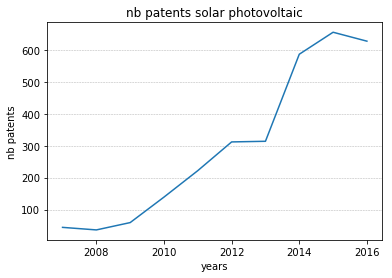

In [9]:
plt_nb_patent(years,dfNbPatent['solar photo'],'years','nb patents','nb patents solar photovoltaic')
plt.figure()

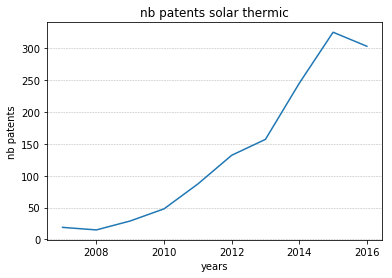

In [10]:
plt_nb_patent(years,dfNbPatent['solar therm'],'years','nb patents','nb patents solar thermic')
plt.figure()

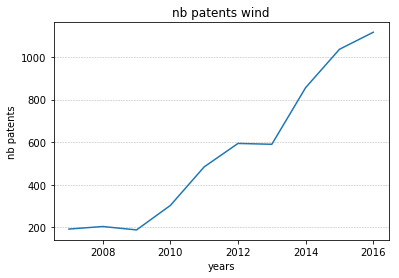

In [11]:
plt_nb_patent(years,dfNbPatent['wind'],'years','nb patents','nb patents wind')
plt.figure()

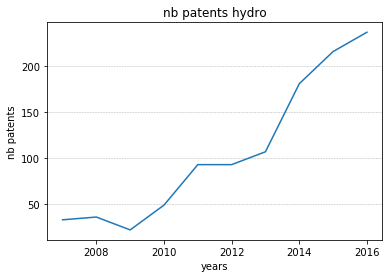

In [12]:
plt_nb_patent(years,dfNbPatent['hydro'],'years','nb patents','nb patents hydro')
plt.figure()

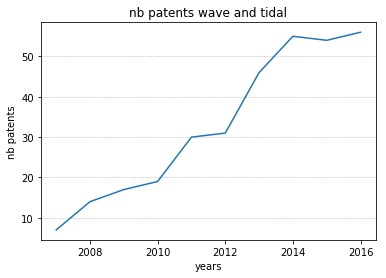

In [13]:
plt_nb_patent(years,dfNbPatent['tidal and wave'],'years','nb patents','nb patents wave and tidal')
plt.figure()

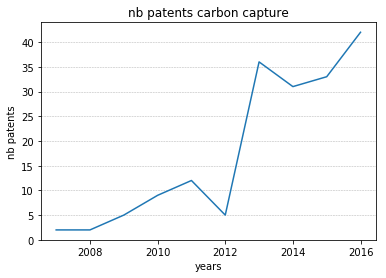

In [14]:
plt_nb_patent(years,dfNbPatent['carbon capture'],'years','nb patents', 'nb patents carbon capture')
plt.figure()

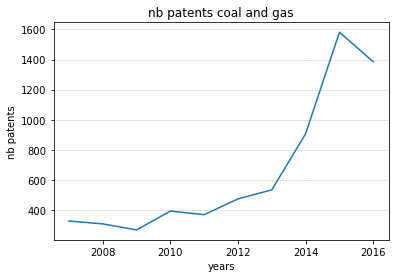

In [15]:
plt_nb_patent(years,dfNbPatent['coal and gas'],'years','nb patents','nb patents coal and gas')
plt.figure()

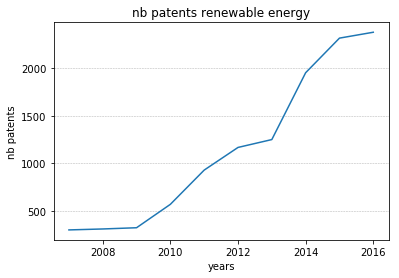

In [16]:
plt_nb_patent(years,dfNbPatent['renewable'],'years','nb patents','nb patents renewable energy')
plt.figure()

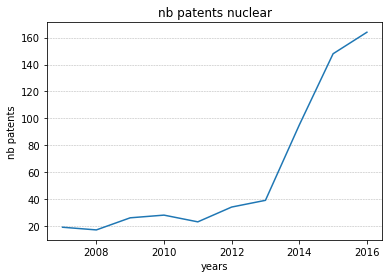

In [17]:
plt_nb_patent(years,dfNbPatent['nuclear energy'],'years','nb patents','nb patents nuclear')

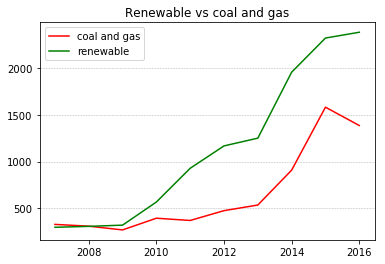

In [18]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(years, dfNbPatent['coal and gas'],'r', label='coal and gas')
ax.plot(years, dfNbPatent['renewable'],'g', label= 'renewable')
ax.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.legend()
plt.title("Renewable vs coal and gas")

In [15]:
from implementations import *

In [20]:
energies = ['solar photo','solar therm','wind','hydro', 'tidal and wave','carbon capture','coal and gas','nuclear energy']

dfEnergyPatentGrowth=pd.DataFrame(columns=['solar photo','solar therm','wind','hydro',
                        'tidal and wave','carbon capture','coal and gas','nuclear energy'])

for energy in energies:
    dfEnergyPatentGrowth[energy] = get_growth(years,list(dfNbPatent[energy]))

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

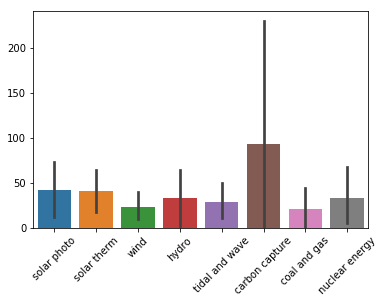

In [21]:
sns.barplot(data=dfEnergyPatentGrowth)
plt.xticks(rotation=45)

In [22]:
dfEnergyPatentGrowth.corr()

,solar photo,solar therm,wind,hydro,tidal and wave,carbon capture,coal and gas,nuclear energy
solar photo,1.000000,0.770742,0.708214,0.651853,-0.346187,-0.196159,0.376685,0.296973
solar therm,0.770742,1.000000,0.430283,0.256640,-0.332398,-0.077810,0.145474,0.274169
wind,0.708214,0.430283,1.000000,0.934295,-0.111408,-0.388760,0.438371,0.043223
hydro,0.651853,0.256640,0.934295,1.000000,0.008101,-0.144509,0.394091,-0.075878
tidal and wave,-0.346187,-0.332398,-0.111408,0.008101,1.000000,0.197868,-0.480574,-0.471622
carbon capture,-0.196159,-0.077810,-0.388760,-0.144509,0.197868,1.000000,-0.197049,-0.193649
coal and gas,0.376685,0.145474,0.438371,0.394091,-0.480574,-0.197049,1.000000,0.644984
nuclear energy,0.296973,0.274169,0.043223,-0.075878,-0.471622,-0.193649,0.644984,1.000000


In [28]:
years=list(range(2010,2017))

In [21]:
dfPatentSolarPhoto = build_dataframe(years,keywords_solar_power,list_ipc_solar_p)
dfPatentSolarThermo = build_dataframe(years,keywords_solar_thermal,list_ipc_solar_t)                                   
dfPatentWind = build_dataframe(years,keywords_wind,list_ipc_wind)  
dfPatentHydro = build_dataframe(years,keywords_hydro,list_ipc_hydro)  
dfPatentWaveTidal = build_dataframe(years,keywords_wave_and_tidal,list_ipc_wave_and_tidal)  
dfPatentCarbonStorage = build_dataframe(years,keywords_carbon_capture_and_storage,list_ipc_carbon_capture_and_storage)  

In [22]:
dfPatentRenewable=pd.concat([dfPatentSolarPhoto,dfPatentSolarThermo,dfPatentWind,
                   dfPatentHydro,dfPatentWaveTidal,dfPatentCarbonStorage], ignore_index=True)

In [23]:
# save individual dataframes
savedfexcel(dfPatentSolarPhoto, 'patent_solar_photo')
savedfexcel(dfPatentSolarThermo, 'patent_solar_thermo')
savedfexcel(dfPatentWind, 'patent_wind')
savedfexcel(dfPatentHydro, 'patent_hydro')
savedfexcel(dfPatentWaveTidal, 'patent_wave_tidal')
savedfexcel(dfPatentCarbonStorage, 'patent_carbon_storage')

# save the merged dataframe
savedfexcel(dfPatentRenewable,'patent_renewable')

In [23]:
# read
#dfNbPatent=pd.read_excel('evolution_nb_patents.xlsx')
dfPatentSolarPhoto = pd.read_excel('patent_solar_photo.xlsx')
dfPatentSolarThermo = pd.read_excel('patent_solar_thermo.xlsx')
dfPatentWind = pd.read_excel('patent_wind.xlsx')
dfPatentHydro = pd.read_excel('patent_hydro.xlsx')
dfPatentWaveTidal = pd.read_excel('patent_wave_tidal.xlsx')
dfPatentCarbonStorage = pd.read_excel('patent_carbon_storage.xlsx')
dfPatentRenewable = pd.read_excel('patent_renewable.xlsx')

In [29]:
# max_n is the maximum number of patents holder, which is the US
dfPatentRenewableMap = df_get_nb_by_group_and_clean(dfPatentRenewable,'inventor_country', years, True)
max_n = dfPatentRenewableMap['total'].max()
#Here, we set up a Colormap using the logarithmic scale as shades of Blue colors that will be used to color the map
colormap = cm.linear.PuBu.scale(0, round(math.log(max_n))).to_step(100)
#Take the log of the number of granted patents to match the logarithmic scale
log_nb = list(map(lambda x: math.log(x) if (x > 0) else 0 , dfPatentRenewableMap['total']))
#In the below DataFrame, each country has now its 'logarithmic color code'
dfPatentRenewableMap['log_color_code'] = log_nb
#We need also to convert the table into a dictionnary, in order to map a feature to its number of patents.
patents_dict = dfPatentRenewableMap['log_color_code']
#Here we map each country to a color according to the "logarithmic" number of patents
color_dict = {key: colormap(patents_dict[key]) for key in patents_dict.keys()}

In [30]:
df_map=df_get_nb_by_group_and_clean(dfPatentRenewable,'inventor_country', years,True).reset_index().copy()
m = folium.Map(location= [46.484, 8.1336],tiles='cartodbpositron',zoom_start=2)  

#Load the world map
countries_geo_path = './data/custom.geo.json'
geo_json_data = json.load(open(countries_geo_path))

#Apply the colors using our defined function ret_color, desribed above
folium.GeoJson(geo_json_data,
               style_function=lambda feature: {
              'fillColor': ret_color(feature, color_dict),
              'weight': .5,
              'fillOpacity': 0.8
               }).add_to(m)

#Setting up the scale 
colormap = cm.linear.PuBu.scale(0, max_n).to_step(50)
colormap.caption = 'Number of patents'
m.add_child(colormap)

m.save('patentsrenewable.html')

In [34]:
def plt_interactive_by_country(sector):
    if sector == 'solar photo':
        df=df_get_nb_by_group_and_clean(dfPatentSolarPhoto,'inventor_country', years, False).head(10)
    if sector == 'solar termal':
        df=df_get_nb_by_group_and_clean(dfPatentSolarThermo,'inventor_country', years, False).head(10)
    if sector == 'wind':
        df=df_get_nb_by_group_and_clean(dfPatentWind,'inventor_country', years, False).head(10)
    if sector == 'hydro':
        df=df_get_nb_by_group_and_clean(dfPatentHydro,'inventor_country',years, False).head(10)
    if sector == 'tidal and wave':
        df=df_get_nb_by_group_and_clean(dfPatentWaveTidal,'inventor_country',years, False).head(10)
    if sector == 'carbon capture':
        df=df_get_nb_by_group_and_clean(dfPatentCarbonStorage,'inventor_country',years, False).head(10)
    if sector == 'renewable':
        df=df_get_nb_by_group_and_clean(dfPatentRenewable,'inventor_country', years, False).head(10)       
    df.plot.barh(stacked=True, fontsize=20, figsize=(20,13), rot=0)
    plt.show()

In [35]:
from ipywidgets import interact, interactive, fixed, interact_manual

interact(plt_interactive_by_country, sector=['solar photo','solar termal','wind','hydro','tidal and wave',
                                        'carbon capture','renewable'])

<function __main__.plt_interactive_by_country>

In [37]:
def plt_interactive_by_company(sector):
    if sector == 'solar photo':
        df=df_get_nb_by_group_and_clean(dfPatentSolarPhoto,'assignee_organization', years, False).head(10)
    if sector == 'solar termal':
        df=df_get_nb_by_group_and_clean(dfPatentSolarThermo,'assignee_organization', years, False).head(10)
    if sector == 'wind':
        df=df_get_nb_by_group_and_clean(dfPatentWind,'assignee_organization', years, False).head(10)
    if sector == 'hydro':
        df=df_get_nb_by_group_and_clean(dfPatentHydro,'assignee_organization',years, False).head(10)
    if sector == 'tidal and wave':
        df=df_get_nb_by_group_and_clean(dfPatentWaveTidal,'assignee_organization', years, False).head(10)
    if sector == 'carbon capture':
        df=df_get_nb_by_group_and_clean(dfPatentCarbonStorage,'assignee_organization', years, False).head(10)
    if sector == 'renewable':
        df=df_get_nb_by_group_and_clean(dfPatentRenewable,'assignee_organization', years, False).head(10)       
    df.plot.barh(stacked=True, fontsize=20, figsize=(20,13), rot=0)
    plt.show()

In [38]:
interact(plt_interactive_by_company, sector=['solar photo','solar termal','wind','hydro','tidal and wave',
                                        'carbon capture','renewable'])

<function __main__.plt_interactive_by_company>